## 1. Import Libraries and Set Device

In [ ]:
# --- General Libraries ---
import os
import warnings

# --- Data Handling ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Image Handling and Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# --- PyTorch and Deep Learning ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# --- Utilities ---
from tqdm import tqdm
import joblib

# --- Warning Suppression ---
warnings.filterwarnings('ignore')


In [ ]:
# Set the device for PyTorch computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device information
print(f"Using {device} device")
print(f"CUDA Available: {torch.cuda.is_available()}")

# If CUDA is available, print additional details
if torch.cuda.is_available():
    print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

## 2. Data Loading and Preprocessing

In [ ]:
root_dir = "lung_colon_image_set"
image_paths = []
multi_labels = []

label_mapping = {
    'lung_n': 0, 'lung_aca': 1, 'lung_scc': 2,
    'colon_n': 3, 'colon_aca': 4
}

class_names = list(label_mapping.keys())

for subfolder in ['lung_image_sets/lung_n', 'lung_image_sets/lung_aca', 'lung_image_sets/lung_scc',
                  'colon_image_sets/colon_n', 'colon_image_sets/colon_aca']:
    class_dir = os.path.join(root_dir, subfolder)
    class_name = subfolder.split('/')[-1]

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        image_paths.append(img_path)
        multi_labels.append(label_mapping[class_name])

print(f"Total Image: {len(image_paths)}")


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.85, 1.15))], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1), 
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Regular transform for test/validation data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class FeatureDataset(Dataset):
    def __init__(self, image_paths, multi_labels, transform=None):
        self.image_paths = image_paths
        self.multi_labels = multi_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.multi_labels[idx]


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, multi_labels, test_size=0.3, random_state=42, stratify=multi_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create datasets with respective transformations
train_dataset = FeatureDataset(X_train, y_train, transform=train_transform)
val_dataset = FeatureDataset(X_val, y_val, transform=test_transform)
test_dataset = FeatureDataset(X_test, y_test, transform=test_transform)

# Create data loaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 3. EfficientNetB3 + Random Forrest

In [ ]:
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
model.classifier = torch.nn.Identity() 
model = model.to(device)
model.eval()

In [ ]:
def extract_features(dataloader, model, device='cuda'):
    all_features = []
    all_labels = []

    model.eval()

    with torch.no_grad(): 
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            features = model(inputs)

            all_features.append(features.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.concatenate(all_features), np.array(all_labels)


In [ ]:
X_train_feat, y_train = extract_features(train_loader, model)
X_test_feat, y_test = extract_features(test_loader, model)

In [ ]:
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi.fit(X_train_feat, y_train)

In [ ]:
# Multiclass prediction
y_multi_pred = rf_multi.predict(X_test_feat)

# Print classification report
print("🔎 Multiclass Classification Report:")
print(classification_report(y_test, y_multi_pred, target_names=[
    "Lung Benign", "Lung ACA", "Lung SCC", "Colon Benign", "Colon ACA"
]))

In [ ]:
print("🔍 Confusion Matrix:")
cm = confusion_matrix(y_test, y_multi_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Lung Benign", "Lung ACA", "Lung SCC", "Colon Benign", "Colon ACA"],
            yticklabels=["Lung Benign", "Lung ACA", "Lung SCC", "Colon Benign", "Colon ACA"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
save_path_rf = "random_forest_model.pth"
joblib.dump(rf_multi, save_path_rf)
print(f"RandomForest model saved to {save_path_rf}")

## 4. Resnet34 Classification Fine Tuning

In [ ]:
resnet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)

resnet34 = resnet34.to(device)

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training One Epoch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights

        running_loss += loss.item()  # Sum the loss for average calculation
        _, predicted = torch.max(outputs, 1)  # Get the class predictions
        total += labels.size(0)  # Number of examples
        correct += (predicted == labels).sum().item()  # Correct predictions count

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()  # Sum the loss for average calculation
            _, predicted = torch.max(outputs, 1)  # Get the class predictions
            total_val += labels.size(0)  # Number of examples
            correct_val += (predicted == labels).sum().item()  # Correct predictions count

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    return avg_val_loss, val_accuracy

In [ ]:
def train(model, train_loader, val_loader, epochs=10, patience=3, device='cuda', save_path="best_resnet_model.pth"):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_loss = float('inf')
    patience_counter = 0

    # Lists to store losses and accuracies for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase (train for one epoch)
        avg_train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Append training metrics to lists for plotting
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase (validate for one epoch)
        avg_val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Append validation metrics to lists for plotting
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0  # Reset counter if validation loss improves

            # Save the best model
            print("Validation loss improved, saving the model...")
            torch.save(model.state_dict(), save_path)  # Save the best model

        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, epochs=50, patience=3, device='cuda')

In [ ]:
def plot_train_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot the training and validation loss and accuracy for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
plot_train_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
def test_model(model, test_loader, device='cuda', class_names=None):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = (correct / total) * 100

    print(f"\nTest Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # 🔍 Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return avg_test_loss, test_accuracy

In [ ]:
test_loss, test_accuracy = test_model(model, test_loader, device='cuda', class_names=class_names)

## 5. Ensemble Method (Weighted Soft Voting)

In [ ]:
def ensemble_predict_weighted_voting(resnet_model, rf_model, test_loader, X_test_feat, class_names, device='cuda', resnet_weight=0.8, rf_weight=0.2):
    resnet_model.eval()
    all_ensemble_preds = []
    all_labels = []

    rf_probs_all = rf_model.predict_proba(X_test_feat)

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_probs = torch.softmax(resnet_outputs, dim=1).cpu().numpy()

            batch_size = images.size(0)
            rf_probs = rf_probs_all[i * batch_size: (i + 1) * batch_size]

            avg_probs = (resnet_probs * resnet_weight + rf_probs * rf_weight)
            ensemble_preds = np.argmax(avg_probs, axis=1)

            all_ensemble_preds.extend(ensemble_preds)
            all_labels.extend(labels.cpu().numpy())

    print("\nEnsemble Model Classification Report:")
    print(classification_report(all_labels, all_ensemble_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_ensemble_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return all_labels, all_ensemble_preds

In [ ]:
true_labels, predicted_labels = ensemble_predict_weighted_voting(
    resnet_model=resnet34,
    rf_model=rf_multi,
    test_loader=test_loader,
    X_test_feat=X_test_feat,
    class_names=class_names,
    device='cuda'
)


### 1. Durum Noktasındaki Eğitim Train

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])



#### 1.1. EFNet + Random Forest

🔎 Multiclass Classification Report:
              precision    recall  f1-score   support

 Lung Benign       0.87      1.00      0.93       750
    Lung ACA       0.92      0.64      0.75       750
    Lung SCC       0.91      0.91      0.91       750
Colon Benign       0.95      0.98      0.97       750
   Colon ACA       0.87      0.97      0.91       750

    accuracy                           0.90      3750
   macro avg       0.90      0.90      0.90      3750
weighted avg       0.90      0.90      0.90      3750

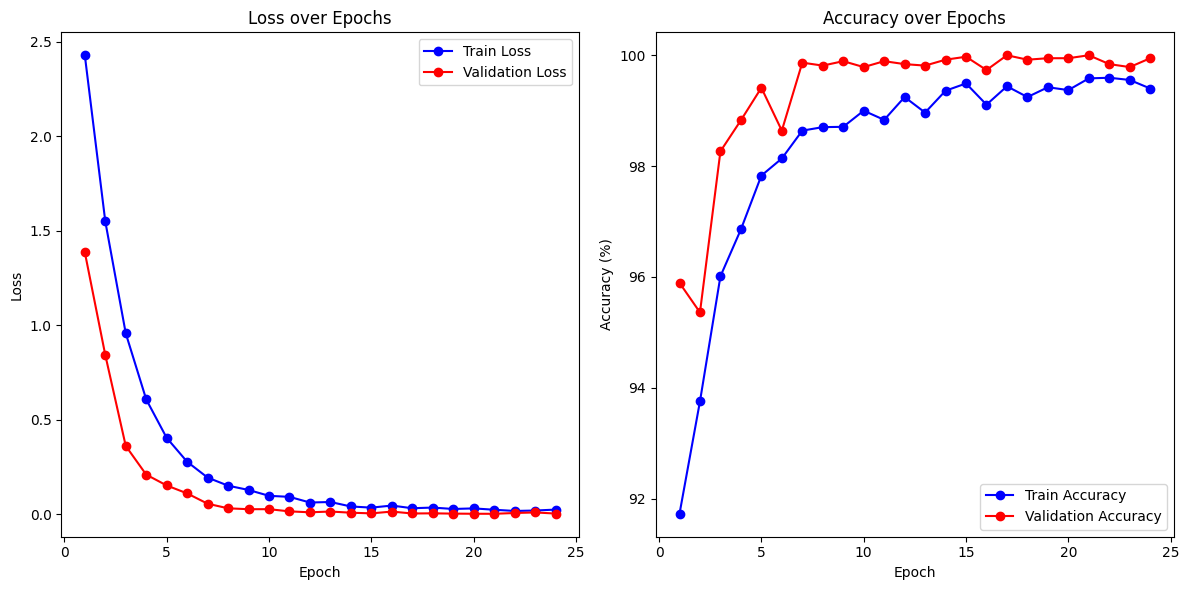

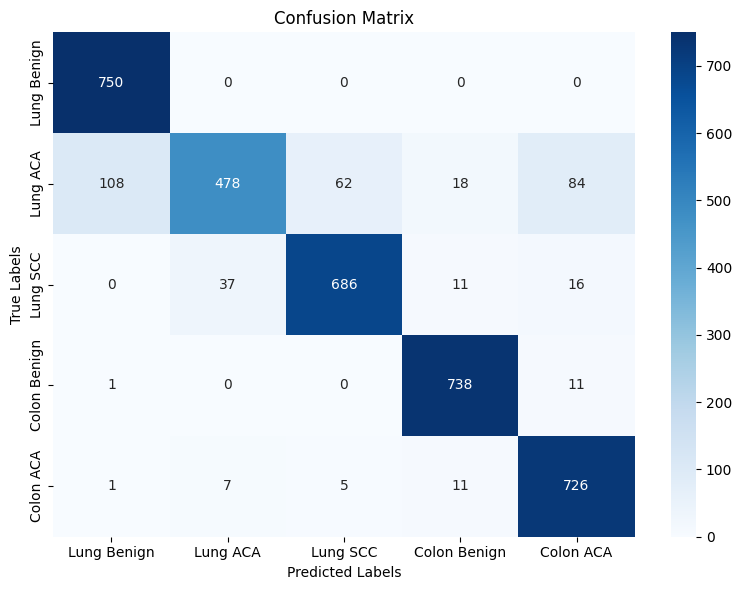

#### 1.2. ResNet Fine Tuning

🧪 Test Loss: 0.0040
✅ Test Accuracy: 99.95%

📊 Classification Report:
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00       750
    lung_aca       1.00      1.00      1.00       750
    lung_scc       1.00      1.00      1.00       750
     colon_n       1.00      1.00      1.00       750
   colon_aca       1.00      1.00      1.00       750

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750

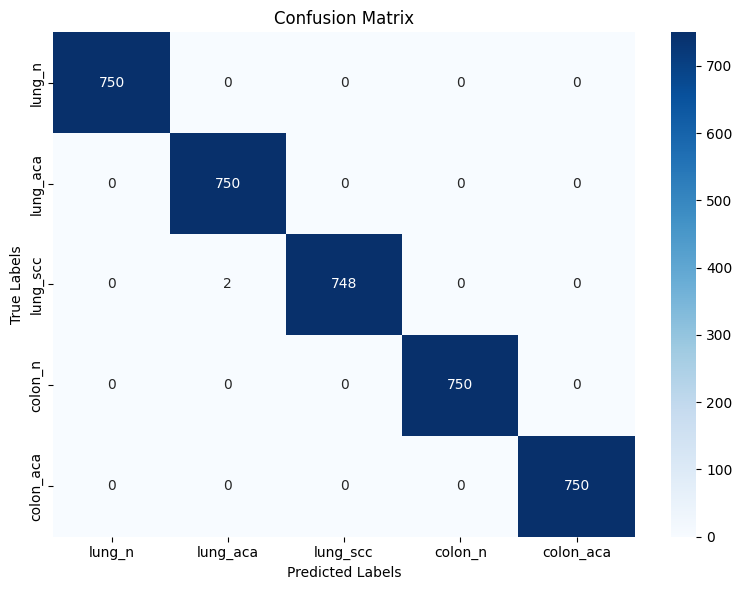

#### 1.3. Weighted Ensemble Result 0.8 Resnet 0.2 Random Forest


Ensemble Model Classification Report:
              precision    recall  f1-score   support

      lung_n       0.94      0.98      0.96       750
    lung_aca       0.88      0.72      0.79       750
    lung_scc       0.88      0.94      0.91       750
     colon_n       0.97      0.97      0.97       750
   colon_aca       0.87      0.93      0.90       750

    accuracy                           0.91      3750
   macro avg       0.91      0.91      0.91      3750
weighted avg       0.91      0.91      0.91      3750


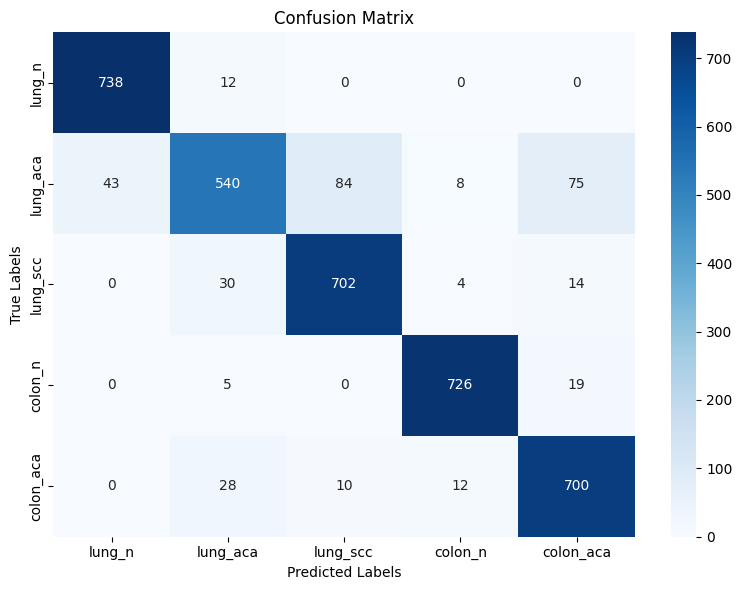